In [1]:
from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from pickle import dump

Using TensorFlow backend.


In [0]:
def extract_features(filename):
# load the model
    model = VGG16()
# re-structure the model
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
# load the photo
    image = load_img(filename, target_size=(224, 224))
# convert the image pixels to a numpy array
    image = img_to_array(image)
# reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature

In [0]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [0]:
def cleanup_summary(summary):
    index = summary.find('startseq ')
    if index > -1:
        summary = summary[len('startseq '):]
        index = summary.find(' endseq')
    if index > -1:
        summary = summary[:index]
    return summary

In [0]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
# integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
# pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
# predict next word
        yhat = model.predict([photo,sequence], verbose=0)
# convert probability to integer
        yhat = argmax(yhat)
# map integer to word
        word = word_for_id(yhat, tokenizer)
# stop if we cannot map the word
        if word is None:
            break
        in_text += ' ' + word
# stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [0]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [0]:
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

In [0]:
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [0]:
def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
                desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions

In [0]:
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [11]:
# load training dataset
filename = 'Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

Dataset: 6000
Descriptions: train=6000


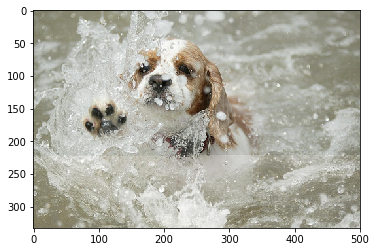

In [30]:
import cv2
import matplotlib.pyplot as plt
path='3383388869_a14552e551.jpg'
img=cv2.imread(path)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

brown dog is running through the water


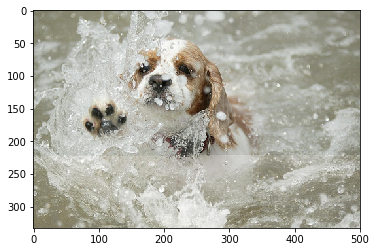

In [31]:
tokenizer = load(open('tokenizer.pkl', 'rb'))
max_length = 30
model = load_model('model.h5')
photo = extract_features(path)
description = generate_desc(model, tokenizer, photo, max_length)
description = cleanup_summary(description)
plt.imshow(img)
print(description)